
# Optimization with Genetic Algorithms  
## Job Shop Scheduling Problem (JSSP)

This notebook simulates a base example used for testing and understanding the genetic algorithm before defining the code structure in Python.  Also to facilitate testing and a comparison of the classes and methods used in the project. 


---
## 1. Problem Description

The Job Shop Scheduling Problem (JSSP) consists of a set of jobs, each composed of a sequence of operations.
Each operation:
- Must be processed on a specific machine
- Has a fixed processing time

### Constraints
- Operations of the same job must respect their predefined order
- A machine can process only one operation at a time
- Once an operation starts, it must finish without interruption

The objective is to **minimize the total completion time (makespan)**.



---
## 2. Chromosome Encoding

### Representation

A **job-based permutation encoding** is used:

- Each chromosome is a list of job identifiers
- Each job identifier appears as many times as operations the job has
- The position of each gene determines the order in which operations are scheduled

### Validity

This encoding **always produces valid solutions by construction**:
- Job precedence is enforced during decoding
- Machine conflicts are resolved by simulation

Therefore, no explicit chromosome validation is required.


In [1]:

import random
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy



---
## 3. Dataset Loader

This function transforms processing time and machine sequence matrices into an internal job representation.


In [2]:

def load_dataset(processing_time, machine_sequence):
    jobs = []
    for j in range(len(processing_time)):
        job = []
        for i in range(len(processing_time[j])):
            job.append((machine_sequence[j][i], processing_time[j][i]))
        jobs.append(job)
    return jobs



---
## 4. Initial Population Generation

Each individual is generated by randomly shuffling the chromosome while preserving the number of operations per job.


In [3]:

def generate_chromosome(jobs):
    chromosome = []
    for j, job in enumerate(jobs):
        chromosome += [j] * len(job)
    random.shuffle(chromosome)
    return chromosome



---
## 5. Fitness Function

### Makespan Computation

The fitness of a chromosome is the **makespan**, defined as the maximum completion time among all jobs.

A discrete-event simulation is performed:
- Job completion times are tracked
- Machine availability is respected
- Operation order constraints are enforced


In [4]:

def fitness(chromosome, jobs):
    job_time = [0]*len(jobs)
    machine_time = {}
    job_op_index = [0]*len(jobs)

    for gene in chromosome:
        op_idx = job_op_index[gene]
        machine, duration = jobs[gene][op_idx]

        start = max(job_time[gene], machine_time.get(machine, 0))
        end = start + duration

        job_time[gene] = end
        machine_time[machine] = end
        job_op_index[gene] += 1

    return max(job_time)



---
## 6. Selection Operators

Two selection mechanisms are implemented and compared:

1. **Tournament Selection** – Promotes selective pressure
2. **Roulette Wheel Selection** – Probability proportional to fitness


In [5]:

def tournament_selection(pop, fits, k=3):
    selected = random.sample(list(zip(pop, fits)), k)
    return deepcopy(min(selected, key=lambda x: x[1])[0])

def roulette_selection(pop, fits):
    inv = [1/f for f in fits]
    probs = [i/sum(inv) for i in inv]
    return deepcopy(pop[np.random.choice(len(pop), p=probs)])



---
## 7. Crossover Operators

Two crossover operators suitable for permutation-based encoding are used:

1. **Order Crossover (OX)**
2. **Position-Based Crossover (PBX)**

Both operators preserve the number of occurrences of each job.


In [6]:

def order_crossover(p1, p2):
    size = len(p1)
    a, b = sorted(random.sample(range(size), 2))
    child = [None]*size
    child[a:b] = p1[a:b]

    required = {g: p1.count(g) for g in set(p1)}
    used = {g: child[a:b].count(g) for g in set(p1)}

    fill = []
    for g in p2:
        if used[g] < required[g]:
            fill.append(g)
            used[g] += 1

    idx = 0
    for i in range(size):
        if child[i] is None:
            child[i] = fill[idx]
            idx += 1
    return child


def position_crossover(p1, p2):
    size = len(p1)
    pos = random.sample(range(size), size//3)
    child = [None]*size

    for p in pos:
        child[p] = p1[p]

    required = {g: p1.count(g) for g in set(p1)}
    used = {g: child.count(g) for g in set(p1)}

    fill = []
    for g in p2:
        if used[g] < required[g]:
            fill.append(g)
            used[g] += 1

    idx = 0
    for i in range(size):
        if child[i] is None:
            child[i] = fill[idx]
            idx += 1
    return child



---
## 8. Mutation Operators

Two mutation strategies are used:

1. **Swap Mutation** – Exchanges two genes
2. **Inversion Mutation** – Reverses a subsequence

These operators maintain solution feasibility.


In [7]:

def swap_mutation(ch):
    a, b = random.sample(range(len(ch)), 2)
    ch[a], ch[b] = ch[b], ch[a]
    return ch

def inversion_mutation(ch):
    a, b = sorted(random.sample(range(len(ch)), 2))
    ch[a:b] = reversed(ch[a:b])
    return ch



---
## 9. Genetic Algorithm

### Parameters
- Population size: fixed
- Stopping criteria:
  - Maximum generations
  - Stationary state detection (no improvement for 30 generations)


In [8]:

def genetic_algorithm(jobs, pop_size, generations, sel, cross, mut, pmut):
    pop = [generate_chromosome(jobs) for _ in range(pop_size)]
    best_hist = []
    best_fit = float('inf')
    stagnant = 0

    for _ in range(generations):
        fits = [fitness(c, jobs) for c in pop]
        best = min(fits)
        best_hist.append(best)

        if best < best_fit:
            best_fit = best
            stagnant = 0
        else:
            stagnant += 1

        if stagnant > 30:
            break

        new_pop = []
        while len(new_pop) < pop_size:
            p1 = sel(pop, fits)
            p2 = sel(pop, fits)
            c = cross(p1, p2)
            if random.random() < pmut:
                c = mut(c)
            new_pop.append(c)
        pop = new_pop

    best_ind = min(pop, key=lambda c: fitness(c, jobs))
    return best_hist, best_ind



---
## 10. Experimental Setup

Three datasets of increasing size are used:
- Small (3–5 machines)
- Medium (~10 machines)
- Large (≥15 machines)

Six parameter configurations are tested, combining different operators.


In [9]:

datasets = {
    "small": (
        [[3,2,2],[2,1,4],[4,3]],
        [[0,1,2],[0,2,1],[1,2]]
    ),
    "medium": (
        [[2,3,2,4],[4,3,3,2],[3,2,4,3],[2,4,3,2]],
        [[0,1,2,3],[1,2,3,0],[2,3,0,1],[3,0,1,2]]
    ),
    "large": (
        [[random.randint(1,5) for _ in range(15)] for _ in range(15)],
        [[i for i in range(15)] for _ in range(15)]
    )
}

configs = [
    (tournament_selection, order_crossover, swap_mutation),
    (tournament_selection, position_crossover, inversion_mutation),
    (roulette_selection, order_crossover, swap_mutation),
    (roulette_selection, position_crossover, inversion_mutation),
    (tournament_selection, order_crossover, inversion_mutation),
    (roulette_selection, position_crossover, swap_mutation),
]

results = {}

for name, data in datasets.items():
    jobs = load_dataset(*data)
    results[name] = []
    for sel, cro, mut in configs:
        hist, _ = genetic_algorithm(jobs, 50, 200, sel, cro, mut, 0.2)
        results[name].append(hist)



---
## 11. Results and Fitness Evolution


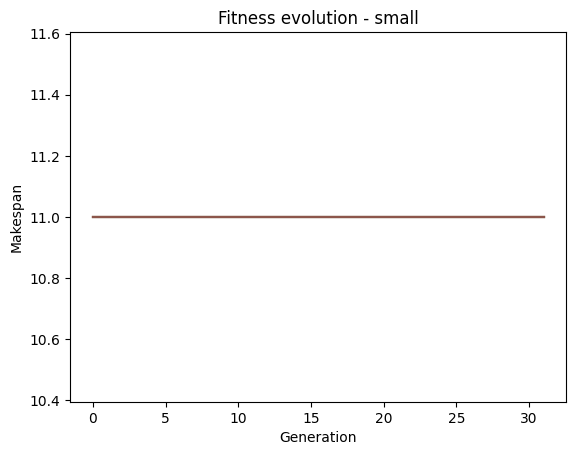

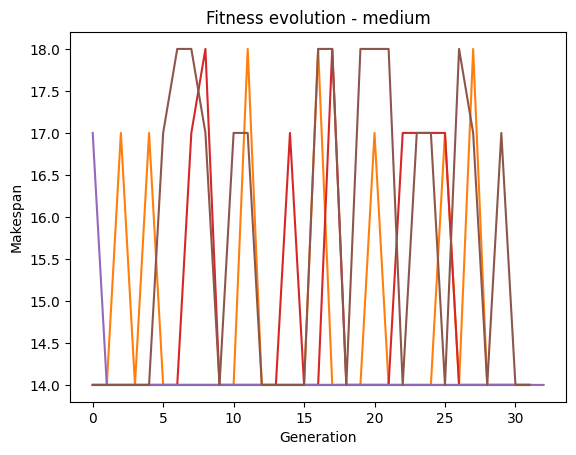

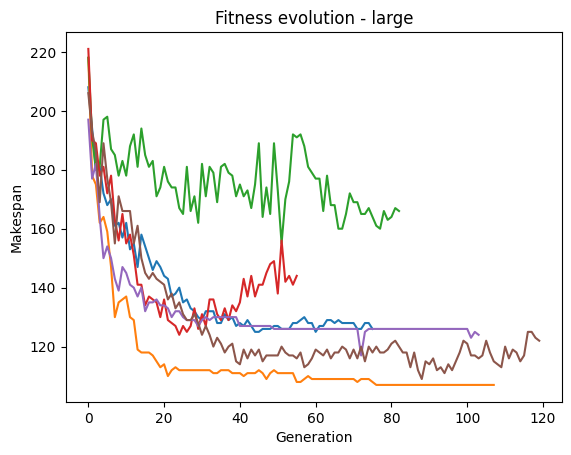

In [10]:

for name, runs in results.items():
    plt.figure()
    for r in runs:
        plt.plot(r)
    plt.title(f"Fitness evolution - {name}")
    plt.xlabel("Generation")
    plt.ylabel("Makespan")
    plt.show()
